In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import utils
import plotting
import os
import glob
import csv, os
import pandas as pd
import nilearn
from nilearn import surface
import warnings
warnings.filterwarnings('ignore')
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels

In [ ]:
# 1. specify the subjects and directories
subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015','PNC016', 'PNC018','PNC019']
micapipe_dir = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'
micapipe_raw = '/data/mica3/BIDS_PNI/rawdata'
hippunfold_dir='/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold'
tmp_dir = 'tmp_func'
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

# 2. Prepare data and analysis parameters 
ses = '01'
hemis = ['L','R']
labels= ['hipp','dentate'] 
tasks= ['patternsep2', 'epiencode','epiretrieve']
t_r = 1.69 
slice_time_ref = 0.0
sigma = 3 #Gaussian smoothing kernal sigma (mm)
ind = [range(419), range(419,483)] # index of how many dentate and hipp vertices are

#3. Load surfaces for downsampling and plotting 
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))

# 0. Map PatternSeparation2 and Episodic Memory data to hippocampal surface

In [76]:
!mkdir -p {tmp_dir}
shp = [419,64]
for sub in subs:

    for task in tasks:
        os.makedirs(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/{task}')

        # convert affines 
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-{task}_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-{task}_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}

                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-{task}_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}


                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-{task}_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
                !{cmd5}

                # downsample
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
                out_array = np.ones((len(func.darrays),shp[l]))
                for k in range(len(func.darrays)):
                    data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                    out_array[k,:] = data
                data_array = nib.gifti.GiftiDataArray(data=out_array)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/{task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_{task}_smooth-{sigma}mm.func.gii')
!rm -r {tmp_dir}

# 1 GLM fit pattern separation2

In [ ]:
last_subject = subs[-1]  # Get the last subject
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']

for sub in subs:
    # Load event files
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-patternsep2_events.tsv'
    events = pd.read_table(events_file)
    df = events
    
    # Recode events so the event is centered on stimulus presentation
    df2 = df[['event_2_onset', 'event_2_duration']]
    df2.rename(columns={'event_2_onset': 'onset', 'event_2_duration': 'duration'}, inplace=True)
    
    # Combine response and condition to get all possible combinations
    true_con = events['condition'] + events["subject response"].astype('str')
    df2['trial_type'] = true_con
    df2['keypress'] = df['event_3_onset']
    
    motion_reg = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-patternsep2_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')
    
    # Load the neocortical timeseries
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-patternsep2_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0], 400))
    for i in range(400):
        texture_neo[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)
    neo_tsL = texture_neo[:, :200]
    neo_tsR = texture_neo[:, 200:]
    
    # Handle the hippocampal/dentate timeseries
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_patternsep2_smooth-3mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_patternsep2_smooth-3mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp, cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp, cdata_dg))

        # Specify the timing of fmri frames 
        n_scans = cdata_hipp.shape[0]
        frame_times = t_r * (np.arange(n_scans) + slice_time_ref)

        design_matrix = make_first_level_design_matrix(frame_times,
                                                      events=df2,
                                                      hrf_model='spm + derivative + dispersion',
                                                      add_regs=motion_reg
                                                      )
        for condition in conditions:
            if condition not in design_matrix.columns:
                # Create columns for condition, its derivatives, and dispersion
                design_matrix[condition] = 0
                design_matrix[f'{condition}_derivative'] = 0
                design_matrix[f'{condition}_dispersion'] = 0

        labels_, estimates = run_glm(combined_array[0:210, :], design_matrix.values[0:210])

        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = dict([(column, contrast_matrix[i])
                    for i, column in enumerate(design_matrix.columns)])

        contrasts = {
        'patternseparation_uncorrected': (
            basic_contrasts['similarsimilar']
            + basic_contrasts['similarsimilar_derivative']
            + basic_contrasts['similarsimilar_dispersion']),
        'patterncompletion_uncorrected': (
            basic_contrasts['oldsimilar']
            + basic_contrasts['oldsimilar_derivative']
            + basic_contrasts['oldsimilar_dispersion']),
        'noveltydetection_uncorrected': (
            basic_contrasts['newnew']
            + basic_contrasts['newnew_derivative']
            + basic_contrasts['newnew_dispersion']),

        'patternseparation': (
            basic_contrasts['similarsimilar']
            - basic_contrasts['similarnew']
            + basic_contrasts['similarsimilar_derivative']
            - basic_contrasts['similarnew_derivative']
            + basic_contrasts['similarsimilar_dispersion']
            - basic_contrasts['similarnew_dispersion']),
        'patterncompletion': (
            basic_contrasts['oldsimilar']
            - basic_contrasts['oldnew']
            + basic_contrasts['oldsimilar_derivative']
            - basic_contrasts['oldnew_derivative']
            + basic_contrasts['oldsimilar_dispersion']
            - basic_contrasts['oldnew_dispersion']),
        'noveltydetection': (
            basic_contrasts['newnew']
            - 0.5*basic_contrasts['oldsimilar']
            - 0.5*basic_contrasts['oldnew']
            + basic_contrasts['newnew_derivative']
            - 0.5*basic_contrasts['oldsimilar_derivative']
            - 0.5*basic_contrasts['oldnew_derivative']
            + basic_contrasts['newnew_dispersion']
            - 0.5*basic_contrasts['oldsimilar_dispersion']
            - 0.5*basic_contrasts['oldnew_dispersion'])}

        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()
    
            data_array_neo = nib.gifti.GiftiDataArray(data=z_score[:200,])
            data_array_hipp = nib.gifti.GiftiDataArray(data=z_score[200:619,])
            data_array_dg = nib.gifti.GiftiDataArray(data=z_score[619:,])

            image_neo = nib.gifti.GiftiImage()
            image_hipp = nib.gifti.GiftiImage()
            image_dg = nib.gifti.GiftiImage()

            image_neo.add_gifti_data_array(data_array_neo)
            image_hipp.add_gifti_data_array(data_array_hipp)
            image_dg.add_gifti_data_array(data_array_dg)

            nib.save(image_neo, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-patternsep2_contrast-{contrast_id}.shape.gii')
            nib.save(image_hipp, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_task-patternsep2_contrast-{contrast_id}.shape.gii')
            nib.save(image_dg, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_task-patternsep2_contrast-{contrast_id}.shape.gii')

    # Check if the current subject is the last subject and plot the design matrix
    if sub == last_subject:
        plt.figure(figsize=(12, 6))
        plt.imshow(design_matrix.values, aspect='auto', cmap='viridis')
        plt.title(f'Design Matrix for Subject {sub}')
        plt.xlabel('Regressors')
        plt.ylabel('Time Points')
        plt.colorbar(label='Regressor Values')
        plt.show()

PermissionError: [Errno 13] Permission denied: '/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold/sub-PNC002/surf/task-fMRI/patternsep2/sub-PNC002_hemi-L_space-T1w_den-2mm_label-schaefer-400_task-patternsep2_contrast-patternseparation_uncorrected.shape.gii'

# 0.3 Plot contrasts to surfaces 

In [201]:
contrast_names=['patternseparation_uncorrected','patterncompletion_uncorrected','noveltydetection_uncorrected','patternseparation','patterncompletion','noveltydetection']
contrasts_patternsep2 = np.ones((483, 2, len(subs), len(contrast_names))) * np.nan
labels= ['hipp','dentate'] 
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrast_names):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-patternsep2_contrast-{contrast_name}.shape.gii'
                try:
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_patternsep2[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrast_name}')

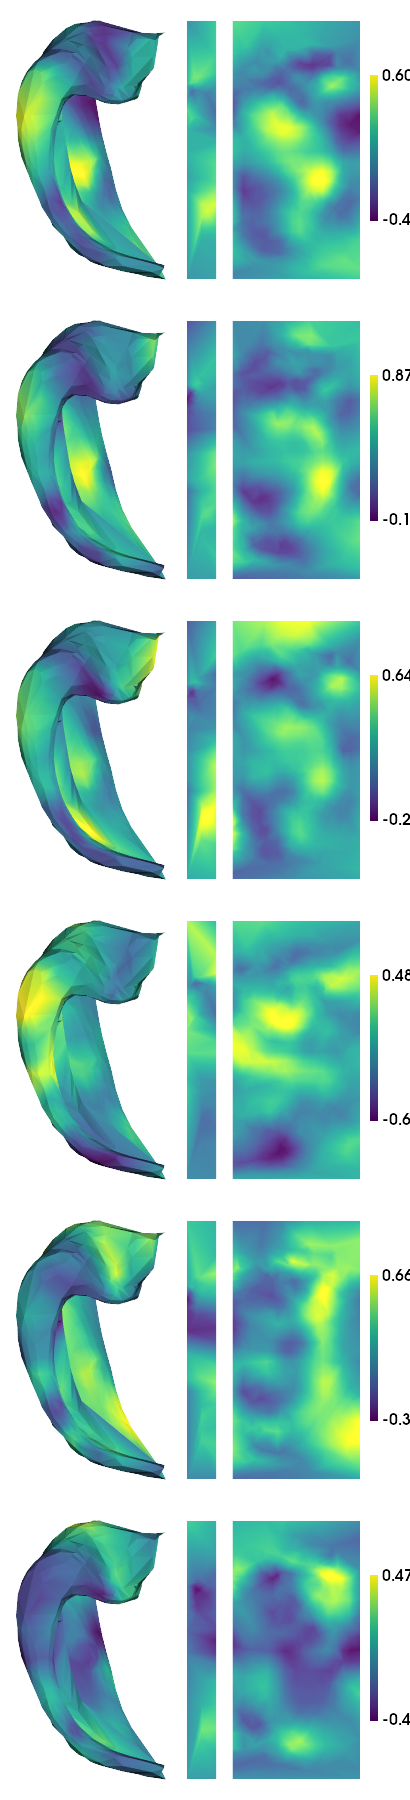

In [202]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_patternsep2,axis=(1,2)), hemis=['L'], den='2mm', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

In [ ]:
#map to neocortical
from nilearn import plotting
c69_inf_lh= read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
labeling = load_parcellation('schaefer', scale=400, join=True)

In [205]:
hemis = ['L', 'R']
contrasts_patternsep2_neo = np.ones((len(subs), 6, 2, 200)) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrast_names):
            contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-patternsep2_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_patternsep2_neo[s, c, h] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrast_name}')


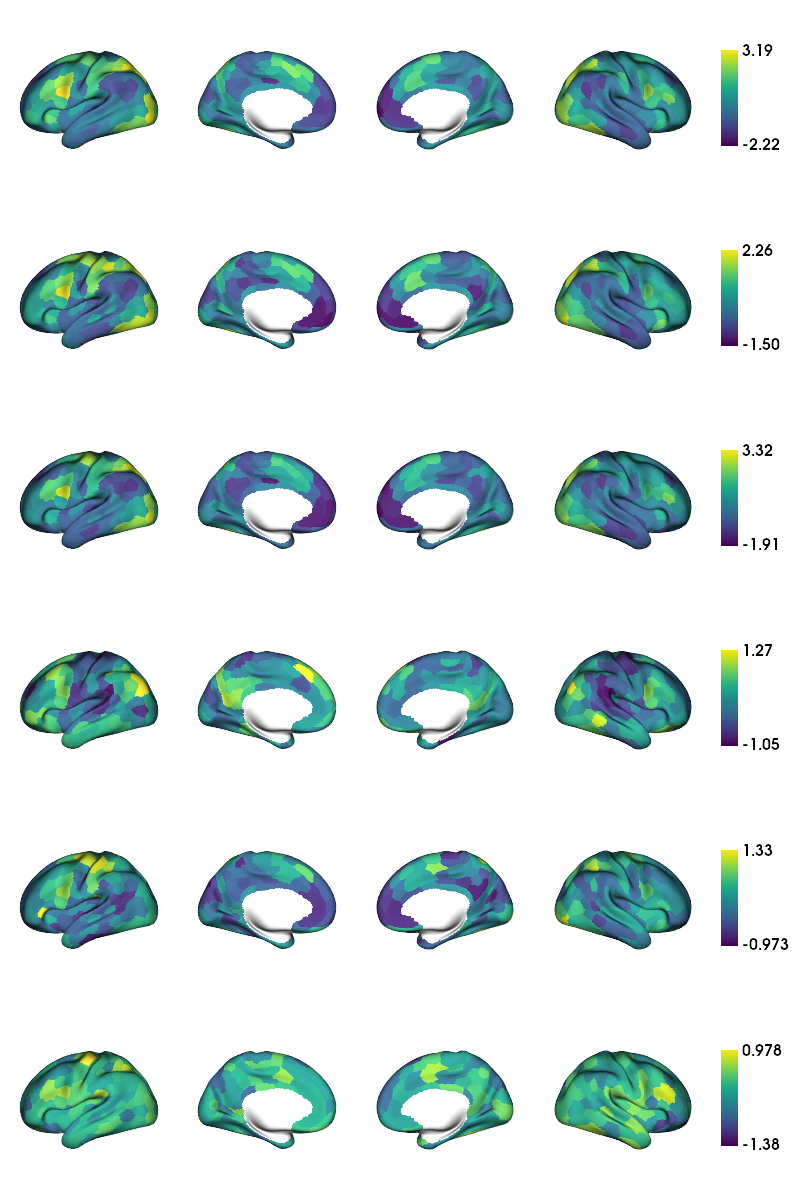

In [207]:
a=np.nanmean(contrasts_patternsep2_neo,axis=0)
original_shape = a.shape
reshaped_a = a.reshape(original_shape[0], original_shape[1] * original_shape[2])
reshaped_a = a.reshape(original_shape[0], original_shape[1] * original_shape[2])

atlas = 'schaefer-400'

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

# Mask of the medial wall
mask_c69 = labels_c69 != 0

mapped_data = []

for i in range(reshaped_a.shape[0]):
    mapped = map_to_labels(reshaped_a[i, :], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, embed_nb=True, nan_color=(1, 1, 1, 1))

# 1.0 GLM fit for episodic retrieval

In [3]:
labels = ['hipp','dentate'] 
for sub in subs:
    
    #load event files 
    
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    events = pd.read_table(events_file)

    df= {"trial_type": [],
            "onset": [],
            'duration': []}

    #recode if fixation and stimulus 
    for i in range(len(events)):
        df['trial_type'].extend(['fixation', 'stimulus'])
        df['onset'].extend([events.loc[i, 'event_1_onset'], events.loc[i, 'event_2_onset']])
        df['duration'].extend([events.loc[i, 'event_1_duration'], events.loc[i, 'event_2_duration']])
    
    
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiretrieve_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')

    
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels): 
            
            fmri_img=nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_epiretrieve_smooth-3mm.func.gii')
            texture= fmri_img.darrays[0].data
                   
            #specify timing of fmri frames 
            n_scans = texture.shape[0]
            frame_times = t_r * (np.arange(n_scans) +  slice_time_ref)
            
            design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=pd.DataFrame.from_dict(df),
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg
                                                  )

            labels_, estimates = run_glm(texture[0:210,:], design_matrix.values[0:210])

            contrast_matrix = np.eye(design_matrix.shape[1])
            basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
           
            contrasts = {
                            'retrieve-fixation': (
                                basic_contrasts['stimulus']
                                - basic_contrasts['fixation']
                                + basic_contrasts['stimulus_derivative']
                                - basic_contrasts['fixation_derivative']
                                + basic_contrasts['stimulus_dispersion']
                                - basic_contrasts['fixation_dispersion'])}            
            
#             # contrast if all retrieval 
#             # contrasts = {'epiretrieve': (basic_contrasts['ALL'])}
            
            
            for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                print(f"  Contrast {index + 1:1} out of {len(contrasts)}: "
                      f"{contrast_id}, left hemisphere")
                # compute contrast-related statistics
                contrast = compute_contrast(labels_, estimates, contrast_val,
                                            contrast_type='t')
                # we present the Z-transform of the t map
                z_score = contrast.z_score()
              
                contrast_name=contrast_id.replace(' ','')
                data_array = nib.gifti.GiftiDataArray(data=z_score)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-epiretrieve_contrast-{contrast_name}.shape.gii')


  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 o

/host/percy/local_raid/donna/anaconda/envs/py39env/lib/python3.9/site-packages/nilearn/_utils/glm.py:332: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 out of 1: retrieve-fixation, left hemisphere
  Contrast 1 o

/host/percy/local_raid/donna/anaconda/envs/py39env/lib/python3.9/site-packages/nilearn/_utils/glm.py:332: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


In [371]:
#stimulus-fixation 
labels=['hipp','dentate']
contast_retfix = np.ones((483,2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            contast_retfix[ind[l],h,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-epiretrieve_contrast-retrieve-fixation.shape.gii').darrays[0].data

/host/percy/local_raid/donna/anaconda/envs/py39env/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


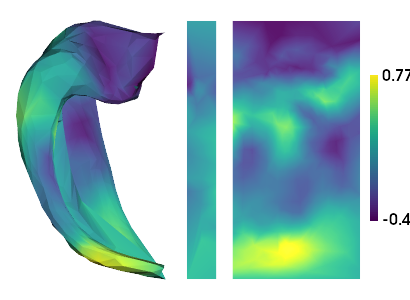

In [372]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contast_retfix,axis=(1,2)), hemis=['L'], den='2mm', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

# Neocortical episodic retrieval 

In [375]:
output_dir = '/host/percy/local_raid/donna/tmp_FC_hippunfold/epiretrieve'
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))
for sub in subs:

    os.makedirs(f'{output_dir}/sub-{sub}')
    
    #load event files 
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    events = pd.read_table(events_file)
    df =events
    
    # Recode events so event is centered on stimulus presentation
    df= {"trial_type": [],
            "onset": [],
            'duration': []}

    #recode if fixation and stimulus 
    for i in range(len(events)):
        df['trial_type'].extend(['fixation', 'stimulus'])
        df['onset'].extend([events.loc[i, 'event_1_onset'], events.loc[i, 'event_2_onset']])
        df['duration'].extend([events.loc[i, 'event_1_duration'], events.loc[i, 'event_2_duration']])
    
    
    #load motion regressors 
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiretrieve_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')
    
    fmri_img=nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiretrieve_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture = np.ones((fmri_img.shape[0],400)) 
    for i in range(400):
         texture[:,i] = np.nanmean(fmri_img[:,parc==(i+1)],axis=1)
    neo_tsL = texture[:,:200]   
    neo_tsR = texture[:,200:]

    #specify timing of fmri frames 
    n_scans = texture.shape[0]
    frame_times = t_r * (np.arange(n_scans) +  slice_time_ref)

    design_matrix = make_first_level_design_matrix(frame_times,
                                          events=pd.DataFrame.from_dict(df),
                                          hrf_model='spm + derivative + dispersion',
                                          add_regs=motion_reg
                                          )

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
               for i, column in enumerate(design_matrix.columns)])

    contrasts = {
                    'retrieve-fixation': (
                        basic_contrasts['stimulus']
                        - basic_contrasts['fixation']
                        + basic_contrasts['stimulus_derivative']
                        - basic_contrasts['fixation_derivative']
                        + basic_contrasts['stimulus_dispersion']
                        - basic_contrasts['fixation_dispersion'])}            

    neo_parc_ts = [neo_tsL, neo_tsR]
    hemis=['L','R']
    for i in range(len(neo_parc_ts)):
        labels, estimates = run_glm(neo_parc_ts[i][0:210, :], design_matrix.values[0:210, :])

        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                print(f"  Contrast {index + 1:1} out of {len(contrasts)}: "
                      f"{contrast_id}, left right hemisphere")

                # compute contrast-related statistics
                contrast = compute_contrast(labels, estimates, contrast_val,contrast_type='t')
                # we present the Z-transform of the t map
                z_score = contrast.z_score()

                contrast_name=contrast_id.replace(' ','')
                data_array = nib.gifti.GiftiDataArray(data=z_score)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{output_dir}/sub-{sub}/sub-{sub}_hemi-{hemis[i]}_surf-fsLR-32k_atlas-schaefer-400_task-epiretrieve_contrast-{contrast_name}.shape.gii')


  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation, left right hemisphere
  Contrast 1 out of 1: retrieve-fixation

In [382]:
output_dir = '/host/percy/local_raid/donna/tmp_FC_hippunfold/epiretrieve'
contrast_names = ['retrieve-fixation']
hemis = ['L', 'R']

contrasts_epiretrieve_neo = np.ones((len(subs), 1, 2, 200)) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrast_names):
            contrast_file = f'{output_dir}/sub-{sub}/sub-{sub}_hemi-{hemi}_surf-fsLR-32k_atlas-schaefer-400_task-epiretrieve_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_epiretrieve_neo[s, c, h] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrast_name}')


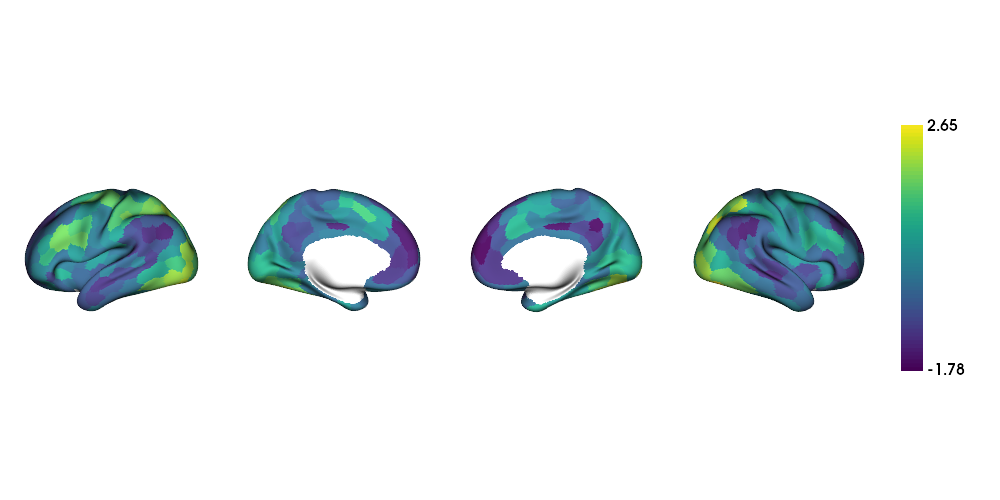

In [386]:
a=np.nanmean(contrasts_epiretrieve_neo,axis=0)
original_shape = a.shape
reshaped_a = a.reshape(original_shape[0], original_shape[1] * original_shape[2])
reshaped_a = a.reshape(original_shape[0], original_shape[1] * original_shape[2])

atlas = 'schaefer-400'
# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

# Mask of the medial wall
mask_c69 = labels_c69 != 0
mapped_data = []

for i in range(reshaped_a.shape[0]):
    mapped = map_to_labels(reshaped_a[i, :], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(1000,500), color_bar=True, embed_nb=True ,nan_color=(1, 1, 1, 1))

# 1.1 GLM fit for episodic retrieval -subsequent memory 

In [9]:
#map episodic encoding data to hippocampal surface
!mkdir -p {tmp_dir}
shp = [419,64]

for sub in subs:
    if not glob.glob(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[-1]}_space-T1w_den-2mm_label-{labels[-1]}_epiencode_smooth-{sigma}mm.func.gii'):

        # convert affines 
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-epiencode_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-epiencode_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}

                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-epiencode_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}


                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiencode_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_epiencode.func.gii '\
                    f'-enclosing'
                !{cmd4}
                
                # smooth

                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_epiencode.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_epiencode_smooth.func.gii '
                !{cmd5}

                # downsample
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_epiencode_smooth.func.gii')
                out_array = np.ones((len(func.darrays),shp[l]))
                for k in range(len(func.darrays)):
                    data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                    out_array[k,:] = data
                data_array = nib.gifti.GiftiDataArray(data=out_array)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_epiencode_smooth-{sigma}mm.func.gii')
                
!rm -r {tmp_dir}

In [44]:
conditions = ['correct', 'incorrect']
output_dir = '/host/percy/local_raid/donna/tmp_FC_hippunfold/epiencode'
labels = ['hipp','dentate'] 
for sub in subs:
    
       # Load encoding and retrieval data
    encoding_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-encoding_events.tsv'
    df_encode = pd.read_table(encoding_file)[['event_2_onset', 'stim_dur', 'stim_1', 'stim_2']]
    df_encode.rename(columns={'event_2_onset': 'onset', 'stim_dur': 'duration'}, inplace=True)

    retrieval_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    df_retrieve = pd.read_table(retrieval_file)[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'accuracy', 'event_3_onset']]
    df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress','accuracy': 'trial_type'}, inplace=True)
    mapping = {0: 'incorrect', 1: 'correct'}
    df_retrieve['trial_type'] = df_retrieve['trial_type'].replace(mapping)
    # Create a design matrix
    new_df = pd.DataFrame()

    # Dictionary to keep track of matched rows in df_retrieve
    matched_rows_dict = {}

    # Iterate through rows in encoding data
    for index, row_encode in df_encode.iterrows():
        stim_1 = row_encode['stim_1']
        stim_2 = row_encode['stim_2']

        # Check if this pair has already been matched
        if (stim_1, stim_2) not in matched_rows_dict:
            # Match rows in retrieval data based on stim_1 and stim_2
            match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

            # If there is exactly one match, append the data to the design matrix
            if len(match_rows) == 1:
                matched_row = match_rows.iloc[0]
                new_df = new_df.append({'onset': row_encode['onset'],
                                                      'duration': row_encode['duration'],
                                                      'prime': matched_row['prime'],
                                                      'target': matched_row['target'],
                                                      'trial_type': matched_row['trial_type']}, ignore_index=True)
                # Update the matched_rows_dict to mark this pair as matched
                matched_rows_dict[(stim_1, stim_2)] = True
            else:
                # If there is no match or multiple matches, mark this pair as unmatched
                matched_rows_dict[(stim_1, stim_2)] = False

    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiencode_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')

    
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels): 
            
            fmri_img=nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_epiencode_smooth-3mm.func.gii')
            texture= fmri_img.darrays[0].data
                   
            #specify timing of fmri frames 
            n_scans = texture.shape[0]
            frame_times = t_r * (np.arange(n_scans) +  slice_time_ref)
            
            design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=new_df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg
                                                  )
            for condition in conditions:
                if condition not in design_matrix.columns:
                    design_matrix[condition] = 0
                    design_matrix[f'{condition}_derivative'] = 0
                    design_matrix[f'{condition}_dispersion'] = 0


            labels_, estimates = run_glm(texture[0:210,:], design_matrix.values[0:210])

            contrast_matrix = np.eye(design_matrix.shape[1])
            basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
          
            contrasts = {
                            'subsequent_memory': (
                                basic_contrasts['correct']
                                + basic_contrasts['correct_derivative']
                                + basic_contrasts['correct_dispersion']),
                            'subsequent_memory_corrected': (
                                basic_contrasts['correct']
                                - basic_contrasts['incorrect']
                                + basic_contrasts['correct_derivative']
                                - basic_contrasts['incorrect_derivative']
                                + basic_contrasts['correct_dispersion']
                                - basic_contrasts['incorrect_dispersion'])}           
            
            for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                
                # compute contrast-related statistics
                contrast = compute_contrast(labels_, estimates, contrast_val,
                                            contrast_type='t')
                # we present the Z-transform of the t map
                z_score = contrast.z_score()
              
                contrast_name=contrast_id.replace(' ','')
                data_array = nib.gifti.GiftiDataArray(data=z_score)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-epiencode_contrast-{contrast_name}.shape.gii')


  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hemisphere
  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hemisphere
  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hemisphere
  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hemisphere
  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hemisphere
  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hemisphere
  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hemisphere
  Contrast 1 out of 2: subsequent_memory, left hemisphere
  Contrast 2 out of 2: subsequent_memory_corrected, left hem

In [46]:
#plot subsequent memory 
contrast_names=['subsequent_memory','subsequent_memory_corrected']
contrasts_epiencode = np.ones((483, 2, len(subs), len(contrast_names))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrast_names):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-epiencode_contrast-{contrast_name}.shape.gii'
                try:
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiencode[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrast_name}')

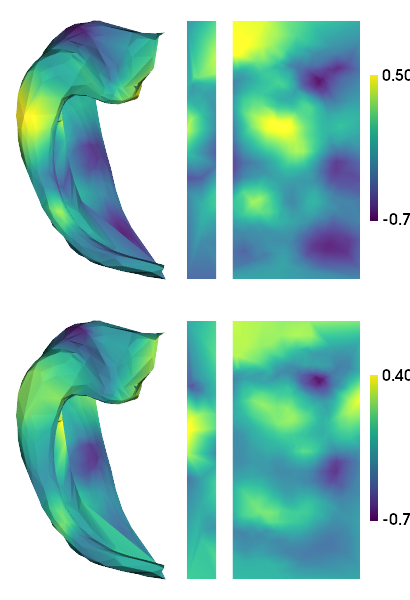

In [48]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiencode,axis=(1,2)), hemis=['L'], den='2mm', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

# 1.2 GLM fit for subsequent memory in the neocortex 

In [50]:
conditions = ['correct', 'incorrect']
output_dir = '/host/percy/local_raid/donna/tmp_FC_hippunfold/epiencode'
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))
for sub in subs:
    os.makedirs(f'{output_dir}/sub-{sub}')

      # Load encoding and retrieval data
    encoding_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-encoding_events.tsv'
    df_encode = pd.read_table(encoding_file)[['event_2_onset', 'stim_dur', 'stim_1', 'stim_2']]
    df_encode.rename(columns={'event_2_onset': 'onset', 'stim_dur': 'duration'}, inplace=True)

    retrieval_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    df_retrieve = pd.read_table(retrieval_file)[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'accuracy', 'event_3_onset']]
    df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress','accuracy': 'trial_type'}, inplace=True)
    mapping = {0: 'incorrect', 1: 'correct'}
    df_retrieve['trial_type'] = df_retrieve['trial_type'].replace(mapping)

    new_df = pd.DataFrame()

    # Dictionary to keep track of matched rows in df_retrieve
    matched_rows_dict = {}

    # Iterate through rows in encoding data
    for index, row_encode in df_encode.iterrows():
        stim_1 = row_encode['stim_1']
        stim_2 = row_encode['stim_2']

        # Check if this pair has already been matched
        if (stim_1, stim_2) not in matched_rows_dict:
            # Match rows in retrieval data based on stim_1 and stim_2
            match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

            # If there is exactly one match, append the data to the design matrix
            if len(match_rows) == 1:
                matched_row = match_rows.iloc[0]
                new_df = new_df.append({'onset': row_encode['onset'],
                                                      'duration': row_encode['duration'],
                                                      'prime': matched_row['prime'],
                                                      'target': matched_row['target'],
                                                      'trial_type': matched_row['trial_type']}, ignore_index=True)
                # Update the matched_rows_dict to mark this pair as matched
                matched_rows_dict[(stim_1, stim_2)] = True
            else:
                # If there is no match or multiple matches, mark this pair as unmatched
                matched_rows_dict[(stim_1, stim_2)] = False

    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiencode_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')

    fmri_img=nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiencode_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture = np.ones((fmri_img.shape[0],400)) 
    for i in range(400):
         texture[:,i] = np.nanmean(fmri_img[:,parc==(i+1)],axis=1)
    neo_tsL = texture[:,:200]   
    neo_tsR = texture[:,200:]

    #specify timing of fmri frames 
    n_scans = texture.shape[0]
    frame_times = t_r * (np.arange(n_scans) +  slice_time_ref)

    design_matrix = make_first_level_design_matrix(frame_times,
                                          events=new_df,
                                          hrf_model='spm + derivative + dispersion',
                                          add_regs=motion_reg
                                          )

    for condition in conditions:
                if condition not in design_matrix.columns:
                    design_matrix[condition] = 0
                    design_matrix[f'{condition}_derivative'] = 0
                    design_matrix[f'{condition}_dispersion'] = 0


    labels_, estimates = run_glm(texture[0:210,:], design_matrix.values[0:210])

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
                    'subsequent_memory_uncorrected': (
                        basic_contrasts['correct']
                        + basic_contrasts['correct_derivative']
                        + basic_contrasts['correct_dispersion']),
                    'subsequent_memory_corrected': (
                        basic_contrasts['correct']
                        - basic_contrasts['incorrect']
                        + basic_contrasts['correct_derivative']
                        - basic_contrasts['incorrect_derivative']
                        + basic_contrasts['correct_dispersion']
                        - basic_contrasts['incorrect_dispersion'])}         

    neo_parc_ts = [neo_tsL, neo_tsR]
    hemis=['L','R']
    for i in range(len(neo_parc_ts)):
        labels, estimates = run_glm(neo_parc_ts[i][0:210, :], design_matrix.values[0:210, :])

        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                # compute contrast-related statistics
                contrast = compute_contrast(labels, estimates, contrast_val,contrast_type='t')
                # we present the Z-transform of the t map
                z_score = contrast.z_score()

                contrast_name=contrast_id.replace(' ','')
                data_array = nib.gifti.GiftiDataArray(data=z_score)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{output_dir}/sub-{sub}/sub-{sub}_hemi-{hemis[i]}_surf-fsLR-32k_atlas-schaefer-400_task-epiencode_contrast-{contrast_name}.shape.gii')


In [52]:
output_dir = '/host/percy/local_raid/donna/tmp_FC_hippunfold/epiencode'
contrast_names=['subsequent_memory_uncorrected','subsequent_memory_corrected']
hemis = ['L', 'R']

contrasts_epiencode_neo = np.ones((len(subs), 2, 2, 200)) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrast_names):
            contrast_file = f'{output_dir}/sub-{sub}/sub-{sub}_hemi-{hemi}_surf-fsLR-32k_atlas-schaefer-400_task-epiencode_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_epiencode_neo[s, c, h] = data  
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrast_name}')


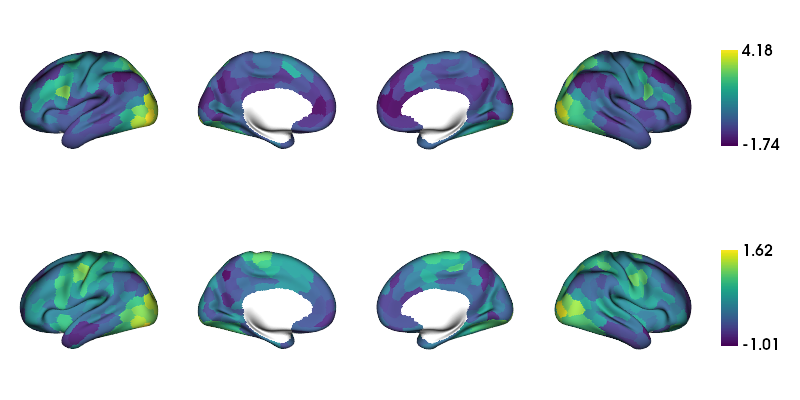

In [53]:
a=np.nanmean(contrasts_epiencode_neo,axis=0)
original_shape = a.shape
reshaped_a = a.reshape(original_shape[0], original_shape[1] * original_shape[2])
reshaped_a = a.reshape(original_shape[0], original_shape[1] * original_shape[2])

atlas = 'schaefer-400'

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

# Mask of the medial wall
mask_c69 = labels_c69 != 0

mapped_data = []

for i in range(reshaped_a.shape[0]):
    mapped = map_to_labels(reshaped_a[i, :], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, embed_nb=True, nan_color=(1, 1, 1, 1))

In [199]:
conditions = ['oldold', 'similarsimilar','newnew','oldsimilar','oldnew','similarold','similarnew','newold','newsimilar']

for sub in subs: 
    
    #load event files 
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-patternsep2_events.tsv'
    events = pd.read_table(events_file)
    df =events
    
    # Recode events so event is centered on stimulus presentation
    df2 = df[['event_2_onset', 'event_2_duration']]
    df2.rename(columns = {'event_2_onset':'onset', 'event_2_duration':'duration'}, inplace = True)
    
    # combine response and condition to get all possible combinations
    true_con= events['condition'] + events["subject response"].astype('str')
    df2['trial_type'] = true_con
    df2['keypress']=df['event_3_onset']
    
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-patternsep2_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')
    
    #load the neocortical timeseries
    fmri_img_neo=nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-patternsep2_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0],400)) 
    for i in range(400):
         texture_neo[:,i] = np.nanmean(fmri_img_neo[:,parc==(i+1)],axis=1)
    neo_tsL = texture_neo[:,:200]   
    neo_tsR = texture_neo[:,200:]
    
# Handle the hippocampal/dentate timeseries
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_patternsep2_smooth-3mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_patternsep2_smooth-3mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp,cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp,cdata_dg))

        # specify timing of fmri frames 
        n_scans = cdata_hipp.shape[0]
        frame_times = t_r * (np.arange(n_scans) +  slice_time_ref)

        design_matrix = make_first_level_design_matrix(frame_times,
                                              events=df2,
                                              hrf_model='spm + derivative + dispersion',
                                              add_regs=motion_reg
                                              )
        for condition in conditions:
            if condition not in design_matrix.columns:
                # Create columns for condition, its derivatives, and dispersion
                design_matrix[condition] = 0
                design_matrix[f'{condition}_derivative'] = 0
                design_matrix[f'{condition}_dispersion'] = 0

        labels_, estimates = run_glm(combined_array[0:210,:], design_matrix.values[0:210])

        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = dict([(column, contrast_matrix[i])
                    for i, column in enumerate(design_matrix.columns)])

        contrasts = {
        'patternseparation_uncorrected': (
            basic_contrasts['similarsimilar']
            + basic_contrasts['similarsimilar_derivative']
            + basic_contrasts['similarsimilar_dispersion']),
        'patterncompletion_uncorrected': (
            basic_contrasts['oldsimilar']
            + basic_contrasts['oldsimilar_derivative']
            + basic_contrasts['oldsimilar_dispersion']),
        'noveltydetection_uncorrected': (
            basic_contrasts['newnew']
            + basic_contrasts['newnew_derivative']
            + basic_contrasts['newnew_dispersion']),

        'patternseparation': (
            basic_contrasts['similarsimilar']
            - basic_contrasts['similarnew']
            + basic_contrasts['similarsimilar_derivative']
            - basic_contrasts['similarnew_derivative']
            + basic_contrasts['similarsimilar_dispersion']
            - basic_contrasts['similarnew_dispersion']),
        'patterncompletion': (
            basic_contrasts['oldsimilar']
            - basic_contrasts['oldnew']
            + basic_contrasts['oldsimilar_derivative']
            - basic_contrasts['oldnew_derivative']
            + basic_contrasts['oldsimilar_dispersion']
            - basic_contrasts['oldnew_dispersion']),
        'noveltydetection': (
            basic_contrasts['newnew']
            - 0.5*basic_contrasts['oldsimilar']
            - 0.5*basic_contrasts['oldnew']
            + basic_contrasts['newnew_derivative']
            - 0.5*basic_contrasts['oldsimilar_derivative']
            - 0.5*basic_contrasts['oldnew_derivative']
            + basic_contrasts['newnew_dispersion']
            - 0.5*basic_contrasts['oldsimilar_dispersion']
            - 0.5*basic_contrasts['oldnew_dispersion'])}

        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # we present the Z-transform of the t map
            z_score = contrast.z_score()
    
            data_array_neo = nib.gifti.GiftiDataArray(data=z_score[:200,])
            data_array_hipp = nib.gifti.GiftiDataArray(data=z_score[200:619,])
            data_array_dg = nib.gifti.GiftiDataArray(data=z_score[619:,])

            image_neo = nib.gifti.GiftiImage()
            image_hipp = nib.gifti.GiftiImage()
            image_dg = nib.gifti.GiftiImage()

            image_neo.add_gifti_data_array(data_array_neo)
            image_hipp.add_gifti_data_array(data_array_hipp)
            image_dg.add_gifti_data_array(data_array_dg)

            nib.save(image_neo, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-patternsep2_contrast-{contrast_id}.shape.gii')
            nib.save(image_hipp, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_task-patternsep2_contrast-{contrast_id}.shape.gii')
            nib.save(image_dg, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_task-patternsep2_contrast-{contrast_id}.shape.gii')